In [1]:
import sys
import os

sys.path.append("H:/Mon Drive/LabMembers/Hamid/Eco_Foundation/Eco_Foundation")
from function import plt,Path_manager_local,utils,utils_2,Split_AnnData 
from  function.Path_manager_local import * 
from  function.utils import *
from  function.utils_2 import *
from  function.Split_AnnData import *

import os, sys , json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import scanpy as sc
from torchinfo import summary

# from importlib import reload

seed = 42
torch.manual_seed(seed)

In [2]:
# Load TMA data (Scanpy AnnData objects)
tma_data = get_tma_objects()  
# By default, it looks for "./data/Processed/Processed_new_TMA_*.h5ad"



# Load EcoFoundation objects
eco_data = get_eco_objects()

Loaded: Processed_new_TMA_1_1.h5ad
Loaded: Processed_new_TMA_1_10.h5ad
Loaded: Processed_new_TMA_1_11.h5ad
Loaded: Processed_new_TMA_1_12.h5ad
Loaded: Processed_new_TMA_1_13.h5ad
Loaded: Processed_new_TMA_1_14.h5ad
Loaded: Processed_new_TMA_1_15.h5ad
Loaded: Processed_new_TMA_1_16.h5ad
Loaded: Processed_new_TMA_1_17.h5ad
Loaded: Processed_new_TMA_1_18.h5ad
Loaded: Processed_new_TMA_1_19.h5ad
Loaded: Processed_new_TMA_1_2.h5ad
Loaded: Processed_new_TMA_1_20.h5ad
Loaded: Processed_new_TMA_1_21.h5ad
Loaded: Processed_new_TMA_1_22.h5ad
Loaded: Processed_new_TMA_1_23.h5ad
Loaded: Processed_new_TMA_1_24.h5ad
Loaded: Processed_new_TMA_1_25.h5ad
Loaded: Processed_new_TMA_1_26.h5ad
Loaded: Processed_new_TMA_1_27.h5ad
Loaded: Processed_new_TMA_1_28.h5ad
Loaded: Processed_new_TMA_1_29.h5ad
Loaded: Processed_new_TMA_1_3.h5ad
Loaded: Processed_new_TMA_1_30.h5ad
Loaded: Processed_new_TMA_1_31.h5ad
Loaded: Processed_new_TMA_1_32.h5ad
Loaded: Processed_new_TMA_1_33.h5ad
Loaded: Processed_new_TMA_1_34.

In [7]:
import torch
import torch.nn as nn
from torch.distributions import Normal, NegativeBinomial
from tqdm import tqdm


class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

        # ZINB Parameters
        self.log_theta = nn.Parameter(torch.zeros(1, output_dim))  # Dispersion
        self.dropout = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Sigmoid())
        self.scale = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Softmax(dim=-1))

    def forward(self, z):
        h = self.relu(self.fc1(z))
        scale = self.scale(h)
        dropout = self.dropout(h)
        theta = torch.exp(self.log_theta)
        return scale, dropout, theta

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, input_dim, hidden_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        scale, dropout, theta = self.decoder(z)
        return mean, logvar, scale, dropout, theta



def zinb_loss(x, scale, dropout, theta, eps=1e-8):
    """ZINB Negative Log Likelihood."""
    # Ensure valid values for theta and scale
    theta = torch.clamp(theta, min=eps)
    scale = torch.clamp(scale, min=eps)

    # Compute Negative Binomial probability
    nb_prob = theta / (theta + scale + eps)
    nb_prob = torch.clamp(nb_prob, min=0.001, max=0.999)  # Stronger clamping

    # Negative Binomial log likelihood

    log_nb = NegativeBinomial(total_count=theta, probs=nb_prob).log_prob(x)

    # Zero inflation
    zero_inflation = torch.log(dropout + (1 - dropout) * torch.exp(log_nb))
    zinb_log_likelihood = torch.where(
        x < eps, zero_inflation, log_nb + torch.log(1 - dropout + eps)
    )

    return -zinb_log_likelihood.sum(dim=1).mean()


In [52]:
class Encoder(nn.Module):
    """
    A multi-layer encoder with optional batchnorm and dropout.
    hidden_dims: list of hidden layer sizes, e.g. [256, 128]
    """
    def __init__(self, input_dim, latent_dim, hidden_dims=[256, 128], dropout_rate=0.1):
        super(Encoder, self).__init__()

        #  build a stack of Linear -> BatchNorm -> ReLU -> Dropout
        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        self.net = nn.Sequential(*layers)

        # Separate linear layers for mean and logvar
        self.mean_layer   = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)

    def forward(self, x):
        h = self.net(x)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

# -------------------------------------------
# Multi-layer Decoder for ZINB
# -------------------------------------------
class Decoder(nn.Module):
    """
    Multi-layer decoder that outputs:
    - scale (mean expression)
    - dropout (zero-inflation probability)
    - theta (dispersion, gene-specific)
    """
    def __init__(self, latent_dim, output_dim, hidden_dims=[128, 256], dropout_rate=0.1):
        super(Decoder, self).__init__()

        # Build a stack (reverse of encoder, e.g. latent -> 128 -> 256 -> ...)
        layers = []
        prev_dim = latent_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        self.net = nn.Sequential(*layers)

        # Separate "heads" for scale and dropout
        self.scale_layer   = nn.Linear(hidden_dims[-1], output_dim)
        self.dropout_layer = nn.Linear(hidden_dims[-1], output_dim)

        # Dispersion parameter per gene
        self.log_theta = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, z):
        h = self.net(z)

        # Mean expression (ensure positivity)
        scale = F.relu(self.scale_layer(h)) + 1e-8

        # Zero-inflation probability in [0, 1]
        dropout = torch.sigmoid(self.dropout_layer(h))

        # Convert log_theta -> theta
        theta = torch.exp(self.log_theta)

        return scale, dropout, theta

# -------------------------------------------
# Full VAE
# -------------------------------------------
class VAE(nn.Module):
    def __init__(
        self,
        input_dim,
        latent_dim=20,
        encoder_hidden_dims=[256, 128],
        decoder_hidden_dims=[128, 256],
        dropout_rate=0.1
    ):
        super(VAE, self).__init__()

        self.encoder = Encoder(
            input_dim=input_dim,
            latent_dim=latent_dim,
            hidden_dims=encoder_hidden_dims,
            dropout_rate=dropout_rate
        )

        self.decoder = Decoder(
            latent_dim=latent_dim,
            output_dim=input_dim,
            hidden_dims=decoder_hidden_dims,
            dropout_rate=dropout_rate
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        scale, dropout, theta = self.decoder(z)
        return mean, logvar, scale, dropout, theta


    def zinb_loss(x, scale, dropout, theta, eps=1e-8):
      """
      x: [batch_size x n_genes], actual count data
      scale: mean expression
      dropout: zero-inflation probability
      theta: dispersion
      """
      theta = torch.clamp(theta, min=eps)
      scale = torch.clamp(scale, min=eps)

      nb_prob = theta / (theta + scale + eps)
      nb_prob = torch.clamp(nb_prob, min=0.00001, max=0.99999)  # reduce numerical instability

      log_nb = NegativeBinomial(total_count=theta, probs=nb_prob).log_prob(x)

      zero_inflation = torch.log(dropout + (1 - dropout) * torch.exp(log_nb) + eps)
      zinb_log_likelihood = torch.where(
          x < eps,
          zero_inflation,
          log_nb + torch.log(1 - dropout + eps)
      )

      return -zinb_log_likelihood.sum(dim=1).mean()

In [61]:
def train_vae(model, train_dataloader, val_dataloader, epochs, optimizer, model_save_dir,
              device, kl_weight=1.0, clip_value=1.0, early_stopping_patience=10, min_delta=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=min_delta)
    best_val_loss = float('inf')

    history = {
        'train_loss': [], 'val_loss': [],
        'train_zinb': [], 'val_zinb': [],
        'train_kl': [], 'val_kl': [],
        'lr': [], 'best_loss': float('inf')
    }

    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, 'best_model.pth')

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        total_train_loss = 0
        train_kld = 0
        train_zinb = 0

        for x in train_dataloader:
            x = x.to(device)
            mean, logvar, scale, dropout, theta = model(x)

            # KLD Regularization
            kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()

            # ZINB Reconstruction Loss
            zinb_recon_loss = zinb_loss(x, scale, dropout, theta)

            loss = zinb_recon_loss + kld * kl_weight

            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            total_train_loss += loss.item()
            train_kld += kld.item()
            train_zinb += zinb_recon_loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_kld = train_kld / len(train_dataloader)
        avg_train_zinb = train_zinb / len(train_dataloader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_kld = 0
        val_zinb = 0

        with torch.no_grad():
            for x in val_dataloader:
                x = x.to(device)
                mean, logvar, scale, dropout, theta = model(x)

                # KLD Regularization
                kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()

                # ZINB Reconstruction Loss
                zinb_recon_loss = zinb_loss(x, scale, dropout, theta)

                loss = zinb_recon_loss + kld * kl_weight
                total_val_loss += loss.item()
                val_kld += kld.item()
                val_zinb += zinb_recon_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_kld = val_kld / len(val_dataloader)
        avg_val_zinb = val_zinb / len(val_dataloader)

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_zinb'].append(avg_train_zinb)
        history['val_zinb'].append(avg_val_zinb)
        history['train_kl'].append(avg_train_kld)
        history['val_kl'].append(avg_val_kld)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Print metrics
        print(f"Epoch {epoch + 1}")
        print(f"Train Loss: {avg_train_loss:.4f} (KLD={avg_train_kld:.4f}, ZINB={avg_train_zinb:.4f})")
        print(f"Val Loss: {avg_val_loss:.4f} (KLD={avg_val_kld:.4f}, ZINB={avg_val_zinb:.4f})")

        # Early stopping and model saving
        early_stopping(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            history['best_loss'] = best_val_loss

            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'history': history,
                'hyperparameters': {
                    'clip_value': clip_value,
                    'early_stopping_patience': early_stopping_patience,
                    'min_delta': min_delta
                }
            }, best_model_path)
            print(f'Best model saved to {best_model_path}')

        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            checkpoint = torch.load(best_model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            break

    # Save final history
    history_path = os.path.join(model_save_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f)
        print(f'Training history saved to {history_path}')

    print('#'*10)

    return model, history

In [54]:
train_dataset, val_dataset = split_data_by_cells(tma_objects, val_ratio=0.2, seed=42)


Split results:
Training: 58 samples, 366873 cells (79.1%)
Validation: 16 samples, 96971 cells (20.9%)


In [55]:

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [56]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")



GPU available: True
GPU name: NVIDIA A100-SXM4-40GB


In [64]:
model = VAE(input_dim=500, latent_dim=50)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [65]:
# Train the model
losses = train_vae(model,
                   train_dataloader,
                   val_dataloader,
                   50, optimizer,
                   '/content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files',
                   device="cuda")

  2%|▏         | 1/50 [00:28<22:52, 28.02s/it]

Epoch 1
Train Loss: 84.3913 (KLD=2.9484, ZINB=81.4428)
Val Loss: 84.0809 (KLD=3.0674, ZINB=81.0136)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


  4%|▍         | 2/50 [00:55<22:23, 27.98s/it]

Epoch 2
Train Loss: 81.4944 (KLD=3.5620, ZINB=77.9324)
Val Loss: 83.4659 (KLD=3.3959, ZINB=80.0700)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


  6%|▌         | 3/50 [01:23<21:52, 27.92s/it]

Epoch 3
Train Loss: 81.1332 (KLD=3.7247, ZINB=77.4086)
Val Loss: 83.3300 (KLD=3.5121, ZINB=79.8179)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


  8%|▊         | 4/50 [01:51<21:21, 27.86s/it]

Epoch 4
Train Loss: 80.9599 (KLD=3.8009, ZINB=77.1591)
Val Loss: 83.2108 (KLD=3.6881, ZINB=79.5227)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 10%|█         | 5/50 [02:19<20:54, 27.87s/it]

Epoch 5
Train Loss: 80.8554 (KLD=3.8467, ZINB=77.0087)
Val Loss: 83.0661 (KLD=3.7327, ZINB=79.3334)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 12%|█▏        | 6/50 [02:47<20:24, 27.82s/it]

Epoch 6
Train Loss: 80.7711 (KLD=3.8947, ZINB=76.8765)
Val Loss: 83.1455 (KLD=3.6077, ZINB=79.5378)
INFO: Early stopping counter 1 of 10


 14%|█▍        | 7/50 [03:14<19:54, 27.77s/it]

Epoch 7
Train Loss: 80.7164 (KLD=3.9122, ZINB=76.8042)
Val Loss: 83.0684 (KLD=3.7354, ZINB=79.3330)
INFO: Early stopping counter 2 of 10


 16%|█▌        | 8/50 [03:42<19:25, 27.74s/it]

Epoch 8
Train Loss: 80.6838 (KLD=3.9402, ZINB=76.7436)
Val Loss: 83.1385 (KLD=3.6976, ZINB=79.4409)
INFO: Early stopping counter 3 of 10


 18%|█▊        | 9/50 [04:10<18:55, 27.68s/it]

Epoch 9
Train Loss: 80.6485 (KLD=3.9536, ZINB=76.6950)
Val Loss: 83.0636 (KLD=3.7098, ZINB=79.3538)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 20%|██        | 10/50 [04:37<18:26, 27.67s/it]

Epoch 10
Train Loss: 80.6254 (KLD=3.9614, ZINB=76.6640)
Val Loss: 82.9904 (KLD=3.7663, ZINB=79.2241)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 22%|██▏       | 11/50 [05:05<17:59, 27.67s/it]

Epoch 11
Train Loss: 80.6122 (KLD=3.9674, ZINB=76.6448)
Val Loss: 83.0763 (KLD=3.7348, ZINB=79.3415)
INFO: Early stopping counter 1 of 10


 24%|██▍       | 12/50 [05:33<17:33, 27.71s/it]

Epoch 12
Train Loss: 80.5997 (KLD=3.9816, ZINB=76.6181)
Val Loss: 83.0500 (KLD=3.7661, ZINB=79.2839)
INFO: Early stopping counter 2 of 10


 26%|██▌       | 13/50 [06:00<17:05, 27.72s/it]

Epoch 13
Train Loss: 80.5886 (KLD=3.9776, ZINB=76.6111)
Val Loss: 83.0363 (KLD=3.7356, ZINB=79.3007)
INFO: Early stopping counter 3 of 10


 28%|██▊       | 14/50 [06:28<16:37, 27.72s/it]

Epoch 14
Train Loss: 80.5822 (KLD=3.9820, ZINB=76.6002)
Val Loss: 83.1304 (KLD=3.7251, ZINB=79.4053)
INFO: Early stopping counter 4 of 10


 30%|███       | 15/50 [06:56<16:11, 27.77s/it]

Epoch 15
Train Loss: 80.5703 (KLD=3.9811, ZINB=76.5892)
Val Loss: 83.0615 (KLD=3.7510, ZINB=79.3105)
INFO: Early stopping counter 5 of 10


 32%|███▏      | 16/50 [07:24<15:43, 27.76s/it]

Epoch 16
Train Loss: 80.5588 (KLD=3.9842, ZINB=76.5746)
Val Loss: 82.9597 (KLD=3.7623, ZINB=79.1974)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 34%|███▍      | 17/50 [07:51<15:13, 27.69s/it]

Epoch 17
Train Loss: 80.5625 (KLD=3.9946, ZINB=76.5679)
Val Loss: 83.0142 (KLD=3.7515, ZINB=79.2627)
INFO: Early stopping counter 1 of 10


 36%|███▌      | 18/50 [08:19<14:45, 27.67s/it]

Epoch 18
Train Loss: 80.5578 (KLD=3.9927, ZINB=76.5651)
Val Loss: 82.9862 (KLD=3.6999, ZINB=79.2863)
INFO: Early stopping counter 2 of 10


 38%|███▊      | 19/50 [08:47<14:18, 27.70s/it]

Epoch 19
Train Loss: 80.5549 (KLD=3.9948, ZINB=76.5601)
Val Loss: 82.9311 (KLD=3.7703, ZINB=79.1608)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 40%|████      | 20/50 [09:14<13:50, 27.68s/it]

Epoch 20
Train Loss: 80.5588 (KLD=3.9971, ZINB=76.5618)
Val Loss: 82.9936 (KLD=3.7571, ZINB=79.2365)
INFO: Early stopping counter 1 of 10


 42%|████▏     | 21/50 [09:42<13:23, 27.69s/it]

Epoch 21
Train Loss: 80.5515 (KLD=4.0004, ZINB=76.5511)
Val Loss: 82.9295 (KLD=3.7433, ZINB=79.1862)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 44%|████▍     | 22/50 [10:10<12:55, 27.70s/it]

Epoch 22
Train Loss: 80.5535 (KLD=4.0019, ZINB=76.5517)
Val Loss: 82.9524 (KLD=3.7614, ZINB=79.1909)
INFO: Early stopping counter 1 of 10


 46%|████▌     | 23/50 [10:37<12:27, 27.70s/it]

Epoch 23
Train Loss: 80.5424 (KLD=3.9954, ZINB=76.5471)
Val Loss: 82.8912 (KLD=3.7321, ZINB=79.1591)
Best model saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/best_model.pth


 48%|████▊     | 24/50 [11:05<11:59, 27.67s/it]

Epoch 24
Train Loss: 80.5475 (KLD=4.0041, ZINB=76.5435)
Val Loss: 83.0286 (KLD=3.7530, ZINB=79.2756)
INFO: Early stopping counter 1 of 10


 50%|█████     | 25/50 [11:33<11:31, 27.67s/it]

Epoch 25
Train Loss: 80.5523 (KLD=4.0027, ZINB=76.5496)
Val Loss: 83.0199 (KLD=3.7067, ZINB=79.3132)
INFO: Early stopping counter 2 of 10


 52%|█████▏    | 26/50 [12:01<11:04, 27.69s/it]

Epoch 26
Train Loss: 80.5494 (KLD=4.0098, ZINB=76.5396)
Val Loss: 82.9471 (KLD=3.7131, ZINB=79.2341)
INFO: Early stopping counter 3 of 10


 54%|█████▍    | 27/50 [12:28<10:37, 27.70s/it]

Epoch 27
Train Loss: 80.5450 (KLD=4.0059, ZINB=76.5392)
Val Loss: 82.9189 (KLD=3.7598, ZINB=79.1590)
INFO: Early stopping counter 4 of 10


 56%|█████▌    | 28/50 [12:56<10:08, 27.67s/it]

Epoch 28
Train Loss: 80.5453 (KLD=4.0077, ZINB=76.5375)
Val Loss: 82.9819 (KLD=3.8277, ZINB=79.1542)
INFO: Early stopping counter 5 of 10


 58%|█████▊    | 29/50 [13:23<09:41, 27.67s/it]

Epoch 29
Train Loss: 80.5390 (KLD=4.0123, ZINB=76.5267)
Val Loss: 82.9183 (KLD=3.7493, ZINB=79.1690)
INFO: Early stopping counter 6 of 10


 60%|██████    | 30/50 [13:51<09:13, 27.68s/it]

Epoch 30
Train Loss: 80.5487 (KLD=4.0075, ZINB=76.5412)
Val Loss: 82.9336 (KLD=3.7766, ZINB=79.1570)
INFO: Early stopping counter 7 of 10


 62%|██████▏   | 31/50 [14:19<08:45, 27.67s/it]

Epoch 31
Train Loss: 80.5304 (KLD=4.0093, ZINB=76.5212)
Val Loss: 83.0524 (KLD=3.8174, ZINB=79.2351)
INFO: Early stopping counter 8 of 10


 64%|██████▍   | 32/50 [14:46<08:17, 27.66s/it]

Epoch 32
Train Loss: 80.5410 (KLD=4.0081, ZINB=76.5330)
Val Loss: 82.9718 (KLD=3.7462, ZINB=79.2256)
INFO: Early stopping counter 9 of 10


 64%|██████▍   | 32/50 [15:14<08:34, 28.59s/it]

Epoch 33
Train Loss: 80.5444 (KLD=4.0091, ZINB=76.5353)
Val Loss: 82.9069 (KLD=3.7993, ZINB=79.1075)
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Early stopping triggered after 33 epochs
Training history saved to /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/training_history.json


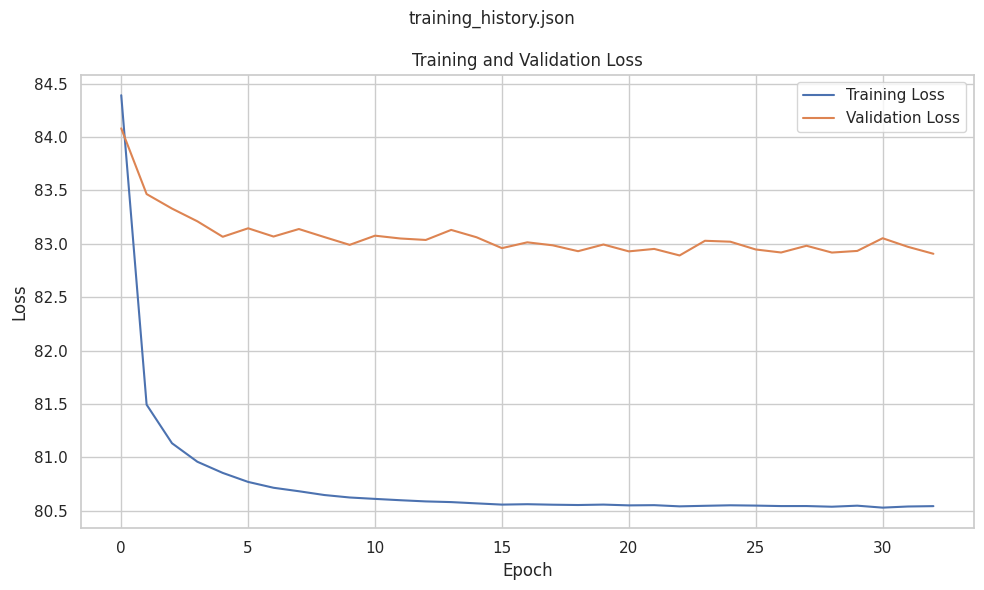

Individual training and validation loss curves saved in /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/Individual_Plots


In [66]:
plot_curves('/content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files')

In [14]:
import importlib
#importlib.reload(utils_2)
import utils_2
from utils_2 import *
import os

In [15]:
trained_model = load_trained_model(model,'/content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v1/Training_files/best_model.pth')
trained_model.training

Model loaded 


False

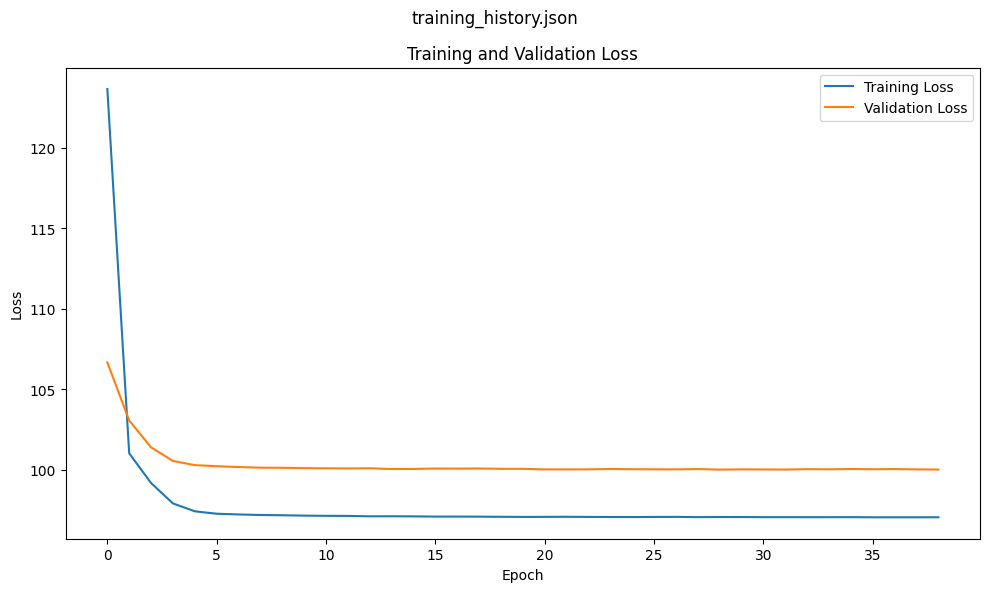

Individual training and validation loss curves saved in /content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v1/Training_files/Individual_Plots


In [16]:
plot_curves('/content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v1/Training_files')

In [17]:

def get_z(model, dataloader, device="cpu"):
    """
    Get latent space representation (z) for all cells.

    Parameters:
        model: Trained VAE model.
        dataloader: DataLoader with the dataset to process.
        device: Device to perform computation on (default: "cpu").

    Returns:
        z_array: Numpy array of shape (n_cells, latent_dim).
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    z_list = []

    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            mean, logvar = model.encoder(x)
            z = model.reparameterize(mean, logvar)  # Use reparameterization trick
            z_list.append(z.cpu().numpy())

    z_array = np.vstack(z_list)  # Combine all batches into one array
    return z_array


In [18]:
# For reconstruction analysis
no_shuffle_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
no_shuffle_val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [19]:
def get_gene_expression(model, z_array, device="cpu"):
    """
    Reconstruct gene expression for all cells using the decoder.

    Parameters:
        model: Trained VAE model.
        z_array: Numpy array of latent space (shape: n_cells x latent_dim).
        device: Device to perform computation on (default: "cpu").

    Returns:
        gene_expression_array: Numpy array of shape (n_cells, n_genes).
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    z_tensor = torch.tensor(z_array, dtype=torch.float32).to(device)  # Convert z_array to tensor
    gene_expression_list = []

    with torch.no_grad():
        for z in z_tensor.split(64):  # Process in batches of 64 to avoid memory issues
            scale, _, _ = model.decoder(z)  # Only use the scale (mean gene expression)
            gene_expression_list.append(scale.cpu().numpy())

    gene_expression_array = np.vstack(gene_expression_list)  # Combine all batches into one array
    return gene_expression_array

In [34]:
adata = tma_objects[1].copy()
adata


AnnData object with n_obs × n_vars = 10323 × 500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'celltype', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Graph_DF', 'barcode_mapping', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'pca', 'spatial', 'umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [35]:
counts =  adata.layers["counts"].toarray()
counts_tensor = torch.tensor(counts, dtype=torch.float32)
dataset = GeneExpressionDataset(counts_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Latent space shape: (10323, 50)
Reconstructed gene expression shape: (10323, 500)


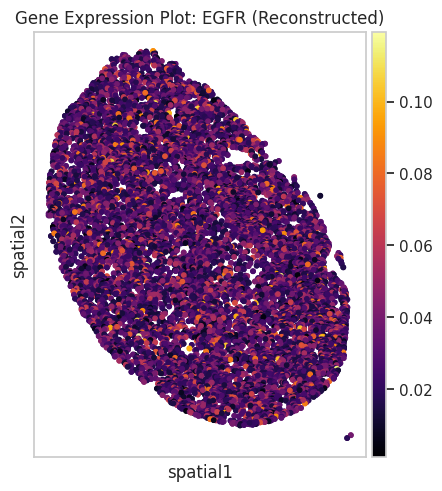

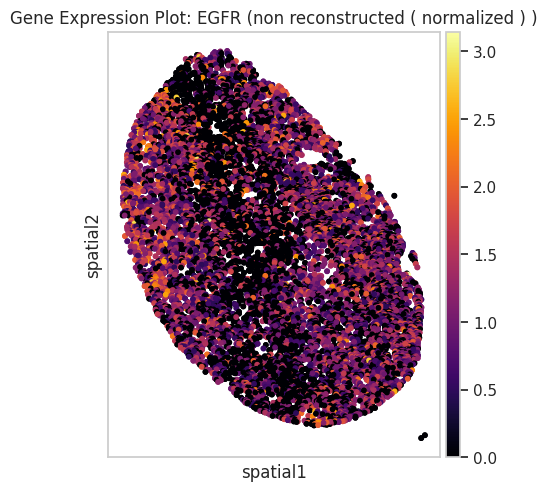

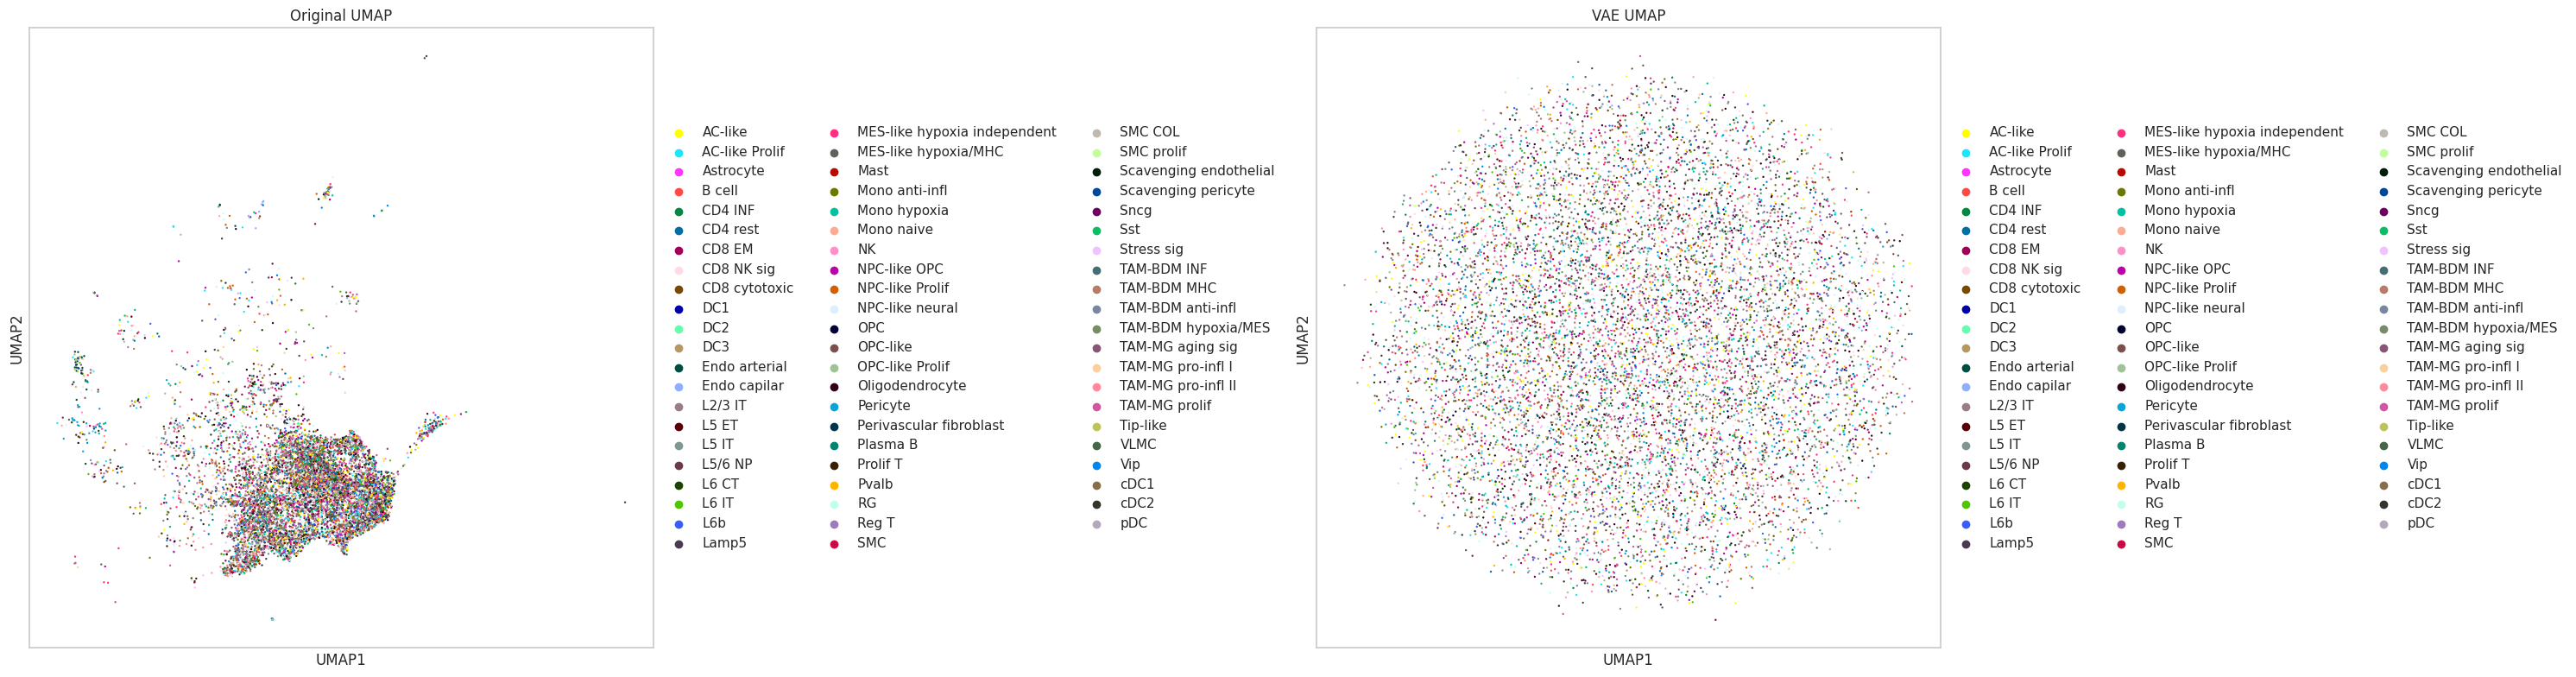

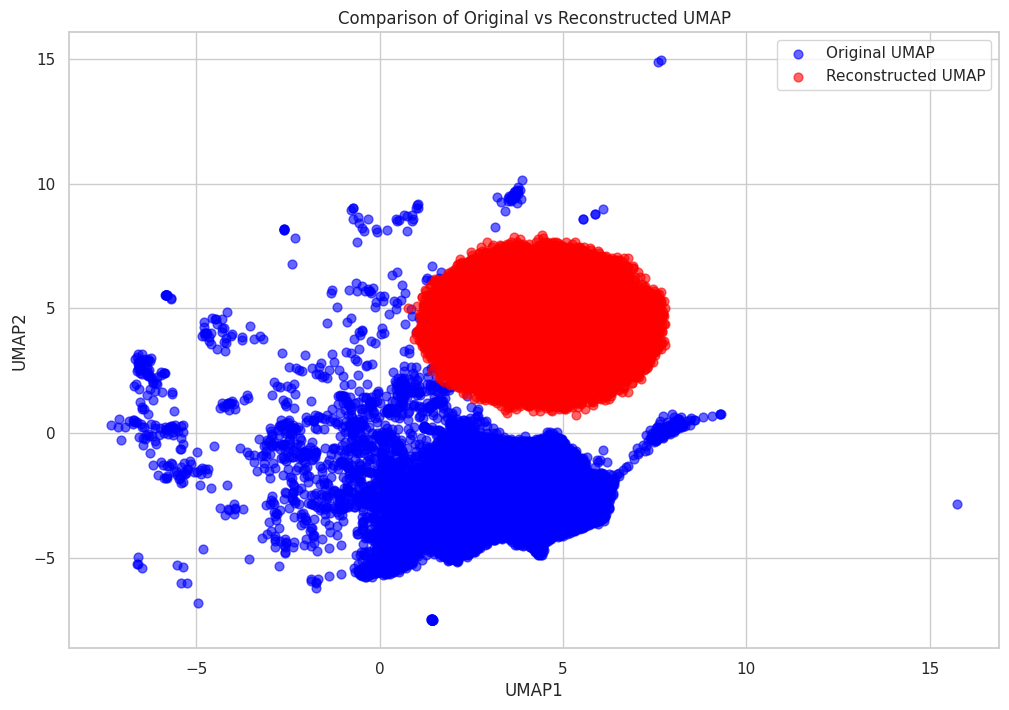


UMAP coordinate correlations:
UMAP1: r=-0.0040 (p=6.8713e-01)
UMAP2: r=-0.0082 (p=4.0532e-01)


In [38]:

def compare_umap_real_vs_reconstructed(trained_model, dataloader, adata, gene="EGFR", device="cpu"):
    """
    Compare Real UMAP with Reconstructed UMAP (VAE Latent Space).
    """
    # Step 1: Get latent space and reconstructions
    Z = get_z(trained_model, dataloader, device=device)
    print("Latent space shape:", Z.shape)
    recon = get_gene_expression(trained_model, Z, device=device)
    print("Reconstructed gene expression shape:", recon.shape)

    # Step 2: Create a copy for UMAP visualization
    adata_vae = adata.copy()

    # Step 3: Store results
    adata_vae.obsm["VAE_latent"] = Z
    adata_vae.layers["X_VAE"] = recon

    # Step 4: Plot Gene Expression if specified
    if gene is not None:
        adata_exp = adata.copy()
        adata_exp.X = recon  # Use reconstructed data
        sns.set(style="whitegrid")
        sq.pl.spatial_scatter(adata_exp,
                            shape=None,
                            color=[gene],
                            size=40,
                            cmap="inferno")
        plt.title(f"Gene Expression Plot: {gene} (Reconstructed)")
        plt.show()

        adata.X = adata.layers["norm"]  # Use original data
        sns.set(style="whitegrid")
        sq.pl.spatial_scatter(adata,
                            shape=None,
                            color=[gene],
                            size=40,
                            cmap="inferno")
        plt.title(f"Gene Expression Plot: {gene} (non reconstructed ( normalized ) )")
        plt.show()


    # Step 5: Get original UMAP (prioritize 'umap' slot)
    original_umap = adata.obsm['umap'].copy()

    # Step 6: Compute new UMAP from latent space
    sc.pp.neighbors(adata_vae, use_rep="VAE_latent")
    sc.tl.umap(adata_vae)
    reconstructed_umap = adata_vae.obsm['X_umap'].copy()

    # Step 7: Plot UMAPs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))

    # Plot original
    adata_vae.obsm['umap'] = original_umap
    sc.pl.umap(adata_vae,
               color=['celltype'],
               ax=ax1,
               show=False,
               title='Original UMAP')

    # Plot reconstructed
    adata_vae.obsm['umap'] = reconstructed_umap
    sc.pl.umap(adata_vae,
               color=['celltype'],
               ax=ax2,
               show=False,
               title='VAE UMAP')

    plt.tight_layout()
    plt.show()

    # Step 8: Plot comparison overlay
    plt.figure(figsize=(12, 8))
    plt.scatter(original_umap[:, 0], original_umap[:, 1],
               c='blue', label='Original UMAP', alpha=0.6, s=40)
    plt.scatter(reconstructed_umap[:, 0], reconstructed_umap[:, 1],
               c='red', label='Reconstructed UMAP', alpha=0.6, s=40)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('Comparison of Original vs Reconstructed UMAP')
    plt.legend()
    plt.show()

    # Print correlations
    corr_umap1, p1 = pearsonr(original_umap[:, 0], reconstructed_umap[:, 0])
    corr_umap2, p2 = pearsonr(original_umap[:, 1], reconstructed_umap[:, 1])
    print(f"\nUMAP coordinate correlations:")
    print(f"UMAP1: r={corr_umap1:.4f} (p={p1:.4e})")
    print(f"UMAP2: r={corr_umap2:.4f} (p={p2:.4e})")

    return original_umap, reconstructed_umap



original, reconstructed = compare_umap_real_vs_reconstructed(
    trained_model=trained_model,
    dataloader=dataloader,
    adata=adata,
    device="cuda"
)

In [37]:
adata

AnnData object with n_obs × n_vars = 10323 × 500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'celltype', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Graph_DF', 'barcode_mapping', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'pca', 'spatial', 'umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
## add library size normalization for VAE

import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import NegativeBinomial
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

####################################################
# 1) A custom Dataset that stores counts + scale_factors
####################################################

class GeneExpressionDatasetSF(Dataset):
    """
    Stores raw count data and a library-size scale factor
    for each cell. Returns (counts_row, scale_factor_row).
    """
    def __init__(self, counts, scale_factors):
        """
        counts:       (N, G) array of raw counts (N = total cells, G = #genes)
        scale_factors (N,)   array of per-cell library scale factors
        """
        super().__init__()
        self.counts = torch.tensor(counts, dtype=torch.float32)
        self.sf = torch.tensor(scale_factors, dtype=torch.float32)

    def __len__(self):
        return self.counts.shape[0]

    def __getitem__(self, idx):
        return self.counts[idx], self.sf[idx]



def split_data_by_cells_with_sf(
    TMA_objects,
    data_type='counts',
    val_ratio=0.2,
    seed=42,
    target_lib_size=1e4
):
    """
    Splits TMA objects (AnnData) at the sample level into
    train/validation sets while targeting ~ val_ratio of total cells,
    and computes library-size scale factors for each cell.

    Parameters
    ----------
    TMA_objects : list of AnnData
        Each AnnData is treated as a single 'sample.'
    data_type : str
        Key in adata.layers to extract the raw counts (default 'counts').
    val_ratio : float
        Fraction of total cells to aim for in validation set.
    seed : int
        Random seed for reproducibility.
    target_lib_size : float
        The library size to which each cell is scaled (e.g., 1e4).

    Returns
    -------
    train_dataset : GeneExpressionDatasetSF
    val_dataset   : GeneExpressionDatasetSF
    """

    torch.manual_seed(seed)

    sample_counts = []
    sample_sfs = []
    cells_per_sample = []

    # 1) Gather data from each sample
    for adata in TMA_objects:
        # Extract raw counts as a 2D NumPy array
        if hasattr(adata.layers[data_type], "A"):
            counts_arr = adata.layers[data_type].A  # sparse .A
        else:
            counts_arr = adata.layers[data_type].toarray()

        n_cells = counts_arr.shape[0]

        # Library size from adata.obs (per cell)
        lib_size = adata.obs["nCount_RNA"].values  # shape = (n_cells,)
        # Per-cell scale factor
        sf = target_lib_size / (lib_size + 1e-8)

        sample_counts.append(counts_arr)
        sample_sfs.append(sf)
        cells_per_sample.append(n_cells)

    total_cells = sum(cells_per_sample)
    target_val_cells = int(val_ratio * total_cells)

    # 2) Shuffle the sample indices
    indices = torch.randperm(len(sample_counts))

    # 3) Accumulate entire samples for val set until we reach ~ val_ratio
    current_val_cells = 0
    split_idx = 0
    for i in indices:
        current_val_cells += cells_per_sample[i]
        split_idx += 1
        if current_val_cells >= target_val_cells:
            break

    val_indices = indices[:split_idx]
    train_indices = indices[split_idx:]

    # 4) Stack train samples
    train_counts_list = []
    train_sf_list     = []
    for i in train_indices:
        train_counts_list.append(sample_counts[i])
        train_sf_list.append(sample_sfs[i])
    train_data = np.vstack(train_counts_list)  # shape = (N_train, G)
    train_sf   = np.concatenate(train_sf_list) # shape = (N_train,)

    # 5) Stack val samples
    val_counts_list = []
    val_sf_list     = []
    for i in val_indices:
        val_counts_list.append(sample_counts[i])
        val_sf_list.append(sample_sfs[i])
    val_data = np.vstack(val_counts_list)      # shape = (N_val, G)
    val_sf   = np.concatenate(val_sf_list)     # shape = (N_val,)

    print("\nSplit results:")
    print(f"  Training: {len(train_indices)} samples, {train_data.shape[0]} cells "
          f"({train_data.shape[0]/total_cells*100:.1f}%)")
    print(f"  Validation: {len(val_indices)} samples, {val_data.shape[0]} cells "
          f"({val_data.shape[0]/total_cells*100:.1f}%)")

    # 6) Create PyTorch datasets
    train_dataset = GeneExpressionDatasetSF(train_data, train_sf)
    val_dataset   = GeneExpressionDatasetSF(val_data,   val_sf)

    return train_dataset, val_dataset



In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[256, 128], dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        self.net = nn.Sequential(*layers)
        self.mean_layer   = nn.Linear(prev_dim, latent_dim)
        self.logvar_layer = nn.Linear(prev_dim, latent_dim)

    def forward(self, x):
        h = self.net(x)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dims=[128,256], dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_dim = latent_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        self.net = nn.Sequential(*layers)
        self.scale_layer   = nn.Linear(prev_dim, output_dim)  # predicted mean
        self.dropout_layer = nn.Linear(prev_dim, output_dim)  # zero-inflation
        self.log_theta     = nn.Parameter(torch.zeros(1, output_dim))  # dispersion

    def forward(self, z):
        h = self.net(z)
        scale   = F.relu(self.scale_layer(h)) + 1e-8
        dropout = torch.sigmoid(self.dropout_layer(h))
        theta   = torch.exp(self.log_theta)
        return scale, dropout, theta


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=20,
                 encoder_hidden_dims=[256,128],
                 decoder_hidden_dims=[128,256],
                 dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim, encoder_hidden_dims, dropout_rate)
        self.decoder = Decoder(latent_dim, input_dim, decoder_hidden_dims, dropout_rate)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        scale, dropout, theta = self.decoder(z)
        return mean, logvar, scale, dropout, theta


In [ ]:
def zinb_loss_with_sf(x, scale, dropout, theta, sf, eps=1e-8):
    """
    'Approach 1' for library-size correction: multiply scale by sf[i] for each cell.
    x:       (batch_size, n_genes) raw counts
    scale:   (batch_size, n_genes) base mean from decoder
    dropout: (batch_size, n_genes) zero-inflation probability
    theta:   (1, n_genes) or (batch_size, n_genes) dispersion
    sf:      (batch_size,) scale factors for each cell
    """
    # Multiply predicted mean by scale_factors
    scale = scale * sf.unsqueeze(1)  # shape = (batch_size, n_genes)

    # Standard ZINB
    theta = torch.clamp(theta, min=eps)
    scale = torch.clamp(scale, min=eps)

    nb_prob = theta / (theta + scale)
    nb_prob = torch.clamp(nb_prob, min=1e-6, max=1-1e-6)

    log_nb = NegativeBinomial(total_count=theta, probs=nb_prob).log_prob(x)
    zero_inflation = torch.log(dropout + (1 - dropout)*torch.exp(log_nb) + eps)

    zinb_ll = torch.where(
        x < eps,  # effectively x==0 if integer
        zero_inflation,
        log_nb + torch.log(1 - dropout + eps)
    )

    return -zinb_ll.sum(dim=1).mean()


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def train_vae_scale_factor(
    model,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    save_dir="./ckpt_scale_factor",
    device="cuda",
    kl_weight=1.0,
    patience=5
):
    os.makedirs(save_dir, exist_ok=True)
    best_path = os.path.join(save_dir, "best_model.pth")

    stopper = EarlyStopping(patience=patience)
    best_val_loss = float("inf")

    history = {
        "train_loss": [], "val_loss": [],
        "train_zinb": [], "val_zinb": [],
        "train_kl": [],   "val_kl": []
    }

    model.to(device)

    for epoch in range(epochs):
        # --- Train ---
        model.train()
        train_loss_sum, train_zinb_sum, train_kl_sum = 0, 0, 0

        for x, sf in train_loader:
            x, sf = x.to(device), sf.to(device)
            optimizer.zero_grad()

            mean, logvar, scale, dropout, theta = model(x)
            kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
            zinb_recon = zinb_loss_with_sf(x, scale, dropout, theta, sf)

            loss = zinb_recon + kl_weight * kl
            loss.backward()
            optimizer.step()

            train_loss_sum  += loss.item()
            train_zinb_sum  += zinb_recon.item()
            train_kl_sum    += kl.item()

        n_train = len(train_loader)
        avg_train_loss = train_loss_sum / n_train
        avg_train_zinb = train_zinb_sum / n_train
        avg_train_kl   = train_kl_sum   / n_train

        # --- Validation ---
        model.eval()
        val_loss_sum, val_zinb_sum, val_kl_sum = 0, 0, 0

        with torch.no_grad():
            for x, sf in val_loader:
                x, sf = x.to(device), sf.to(device)
                mean, logvar, scale, dropout, theta = model(x)
                kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
                zinb_recon = zinb_loss_with_sf(x, scale, dropout, theta, sf)

                val_batch_loss = zinb_recon + kl_weight * kl
                val_loss_sum  += val_batch_loss.item()
                val_zinb_sum  += zinb_recon.item()
                val_kl_sum    += kl.item()

        n_val = len(val_loader)
        avg_val_loss = val_loss_sum / n_val
        avg_val_zinb = val_zinb_sum / n_val
        avg_val_kl   = val_kl_sum   / n_val

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_zinb"].append(avg_train_zinb)
        history["val_zinb"].append(avg_val_zinb)
        history["train_kl"].append(avg_train_kl)
        history["val_kl"].append(avg_val_kl)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train: loss={avg_train_loss:.4f} (ZINB={avg_train_zinb:.4f}, KL={avg_train_kl:.4f})")
        print(f"  Val:   loss={avg_val_loss:.4f}   (ZINB={avg_val_zinb:.4f}, KL={avg_val_kl:.4f})")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)

        stopper(avg_val_loss)
        if stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # load best
    model.load_state_dict(torch.load(best_path))

    # Save history
    hist_path = os.path.join(save_dir, "training_history.json")
    with open(hist_path, "w") as f:
        json.dump(history, f)

    print("Training complete. Best model loaded. History saved.")
    return model, history


In [ ]:
 # 1) Split into train/val at the sample level, computing scale factors
    train_dataset, val_dataset = split_data_by_cells_with_sf(
        TMA_objects,
        data_type='counts',
        val_ratio=0.2,
        seed=42,
        target_lib_size=1e4
    )

    # 2) Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

    # 3) Setup VAE
    n_genes = train_dataset.counts.shape[1]
    model = VAE(
        input_dim=n_genes,
        latent_dim=20,
        encoder_hidden_dims=[256,128],
        decoder_hidden_dims=[128,256],
        dropout_rate=0.1
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 4) Train
    trained_model, history = train_vae_scale_factor(
        model,
        train_loader,
        val_loader,
        epochs=50,
        optimizer=optimizer,
        save_dir="content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/scale_factor_approach",
        device=device,
        kl_weight=1.0,
        patience=5
    )

